In [36]:
# DATASET LOADING AND PROCESSING (DO NEED TO MODIFY)
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam


def plot_airfoils(airfoil_x, airfoil_y):
    '''
    plot airfoils: no need to modify 
    '''
    idx = 0
    fig, ax = plt.subplots(nrows=4, ncols=4)
    for row in ax:
        for col in row:
            col.scatter(airfoil_x, airfoil_y[idx, :], s=0.6, c='black')
            col.axis('off')
            col.axis('equal')
            idx += 1
    plt.show()


class AirfoilDataset(Dataset):
    '''
    airfoil dataset: no need to modify
    '''
    def __init__(self, path='./airfoils/airfoils'):
        super(AirfoilDataset, self).__init__()
        self._X = []	# x coordinates of all airfoils (shared)
        self._Y = []	# y coordinates of all airfoils
        self.names = []	# name of all airfoils
        self.norm_coeff = 0	# normalization coeff to scale y to [-1, 1]
        airfoil_fn = [afn for afn in os.listdir(path) if afn.endswith('.dat')]
        

        # get x coordinates of all airfoils
        with open(os.path.join(path, airfoil_fn[0]), 'r', encoding="utf8", errors='ignore') as f:
            raw_data = f.readlines()
            for idx in range(len(raw_data)):
                raw_xy = raw_data[idx].split(' ')
                while "" in raw_xy:
                    raw_xy.remove("")
                self._X.append(float(raw_xy[0]))
        self._X = np.array(self._X)

        # get y coordinates of each airfoils
        for idx, fn in enumerate(airfoil_fn):
            with open(os.path.join(path, fn), 'r', encoding="utf8", errors='ignore') as f:
                self.names.append(fn[:-10])
                raw_data = f.readlines()
                airfoil = np.empty(self._X.shape[0])
                for i in range(len(raw_data)):
                    raw_xy = raw_data[i].split(' ')
                    while "" in raw_xy:
                        raw_xy.remove("")
                    curr_y = float(raw_xy[1])
                    airfoil[i] = curr_y
                    self.norm_coeff = max(self.norm_coeff, np.abs(curr_y))
                self._Y.append(airfoil)

        self._Y = np.array([airfoil / self.norm_coeff for airfoil in self._Y], dtype=np.float32)

    def get_x(self):
        '''
        get shared x coordinates
        '''
        return self._X

    def get_y(self):
        '''
        get y coordinates of all airfoils
        '''
        return self._Y

    def __getitem__(self, idx):
        return self._Y[idx], self.names[idx]

    def __len__(self):
        return len(self._Y)\
    


# VAE

In [37]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        # build your model here
        # your model should output a predicted mean and a predicted std of the encoding
        # both should be of dim (batch_size, latent_dim)
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2_mean = nn.Linear(128, latent_dim)
        self.fc2_logvar = nn.Linear(128, latent_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        mean = self.fc2_mean(x)
        logvar = self.fc2_logvar(x)
        return mean, logvar


class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        # build your model here
        # your output should be of dim (batch_size, output_dim)
        # you can use tanh() as the activation for the last layer
        # since y coord of airfoils range from -1 to 1
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))  # Using tanh for output since y coordinates range from -1 to 1
        return x


class VAE(nn.Module):
    def __init__(self, airfoil_dim, latent_dim):
        super(VAE, self).__init__()
        self.enc = Encoder(airfoil_dim, latent_dim)
        self.dec = Decoder(latent_dim, airfoil_dim)
    
    def forward(self, x):
        # define your feedforward pass
        mean, logvar = self.enc(x)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps * std
        recon_x = self.dec(z)
        return recon_x, mean, logvar

    def decode(self, z):
        # given random noise z, generate airfoils
        return self.dec(z)

VAE model:
 VAE(
  (enc): Encoder(
    (fc1): Linear(in_features=200, out_features=128, bias=True)
    (fc2_mean): Linear(in_features=128, out_features=16, bias=True)
    (fc2_logvar): Linear(in_features=128, out_features=16, bias=True)
  )
  (dec): Decoder(
    (fc1): Linear(in_features=16, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=200, bias=True)
  )
)
Hyperparameters:
latent dimension: 16
learning rate: 0.001
number of epochs: 30
Epoch: [0/30], Batch: 96, loss: 17.714569091796875
Epoch: [1/30], Batch: 96, loss: 12.873363494873047
Epoch: [2/30], Batch: 96, loss: 15.804736137390137
Epoch: [3/30], Batch: 96, loss: 5.38202428817749
Epoch: [4/30], Batch: 96, loss: 7.6493988037109375
Epoch: [5/30], Batch: 96, loss: 11.117573738098145
Epoch: [6/30], Batch: 96, loss: 8.089262962341309
Epoch: [7/30], Batch: 96, loss: 6.607193470001221
Epoch: [8/30], Batch: 96, loss: 7.480695724487305
Epoch: [9/30], Batch: 96, loss: 9.203948974609375
Epoch: [10/30], Batch: 9

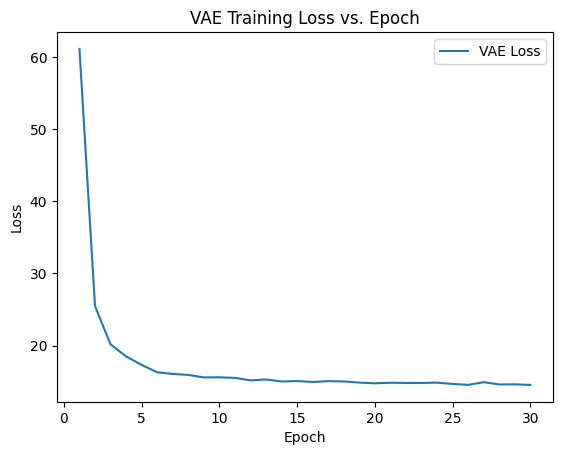

Real Airfoils


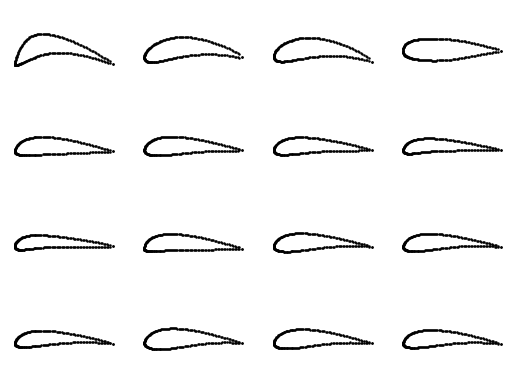

Reconstructed Airfoils


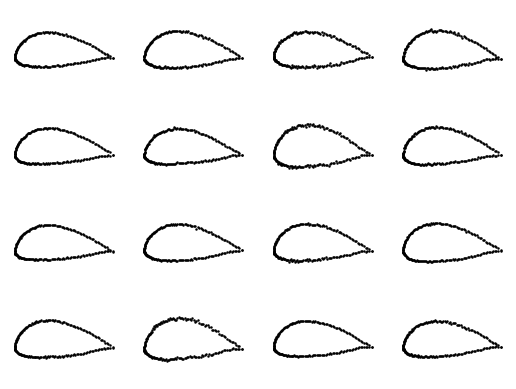

Synthesized Airfoils


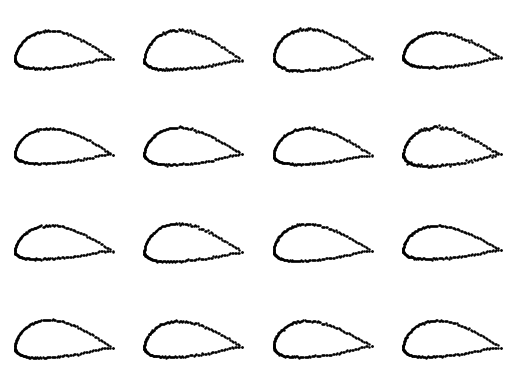

In [38]:
# check if cuda available
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# define dataset and dataloader
dataset = AirfoilDataset()
airfoil_x = dataset.get_x()
airfoil_dim = airfoil_x.shape[0]
airfoil_dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# hyperparameters
latent_dim = 16 # please do not change latent dimension
lr = 0.001      # learning rate
num_epochs = 30

# build the model
vae = VAE(airfoil_dim=airfoil_dim, latent_dim=latent_dim).to(device)

# Print the model architecture
print("VAE model:\n", vae)

print("Hyperparameters:")
print(f"latent dimension: {latent_dim}")
print(f"learning rate: {lr}")
print(f"number of epochs: {num_epochs}")


# define your loss function here
# loss = ?
def vae_loss(recon_x, x, mean, logvar):
    # Reconstruction Loss (MSE Loss)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    # KL Divergence Loss
    kl_div_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

    # Total VAE Loss
    total_loss = recon_loss + kl_div_loss
    return total_loss


# define optimizer for discriminator and generator separately
optim = Adam(vae.parameters(), lr=lr)

# train the VAE model
vae_losses = []  # List to store VAE training losses
for epoch in range(num_epochs):
    epoch_loss = 0.0  # Initialize epoch loss

    for n_batch, (local_batch, __) in enumerate(airfoil_dataloader):
        y_real = local_batch.to(device)

        # train VAE
        recon_y, mean, logvar = vae(y_real)
        loss = vae_loss(recon_y, y_real, mean, logvar)

        # calculate customized VAE loss
        # loss = your_loss_func(...)

        optim.zero_grad()
        loss.backward()
        optim.step()

        epoch_loss += loss.item()  # Add batch loss to epoch loss

    # Calculate average epoch loss
    epoch_loss /= len(airfoil_dataloader)
    vae_losses.append(epoch_loss)  # Append epoch loss to the list

    # print loss while training
    # if (n_batch + 1) % 30 == 0:
    print("Epoch: [{}/{}], Batch: {}, loss: {}".format(epoch, num_epochs, n_batch, loss.item()))

# Plot VAE training loss vs. epoch
plt.plot(range(1, num_epochs + 1), vae_losses, label='VAE Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Loss vs. Epoch')
plt.legend()
plt.show()

# test trained VAE model
num_samples = 100

# reconstuct airfoils
real_airfoils = dataset.get_y()[:num_samples]
recon_airfoils, __, __ = vae(torch.from_numpy(real_airfoils).to(device))
if 'cuda' in device:
    recon_airfoils = recon_airfoils.detach().cpu().numpy()
else:
    recon_airfoils = recon_airfoils.detach().numpy()

# randomly synthesize airfoils
noise = torch.randn((num_samples, latent_dim)).to(device)   # create random noise 
gen_airfoils = vae.decode(noise)
if 'cuda' in device:
    gen_airfoils = gen_airfoils.detach().cpu().numpy()
else:
    gen_airfoils = gen_airfoils.detach().numpy()

# Save VAE model
torch.save(vae.state_dict(), 'vae_model.pth')

# Plot real airfoils
print('Real Airfoils')
plot_airfoils(airfoil_x, real_airfoils)

# Plot reconstructed airfoils
print('Reconstructed Airfoils')
plot_airfoils(airfoil_x, recon_airfoils)

# Plot synthesized airfoils
print('Synthesized Airfoils')
plot_airfoils(airfoil_x, gen_airfoils)



# GAN

In [58]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        # build your model here
        # your output should be of dim (batch_size, 1)
        # since discriminator is a binary classifier
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256,512)
        self.fc3 = nn.Linear(512, 1)

    
    def forward(self, x):
        # define your feed forward pass
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Using sigmoid for binary classification
        return x


class Generator(nn.Module):
    def __init__(self, latent_dim, airfoil_dim):
        super(Generator, self).__init__()
        # build your model here
        # your output should be of dim (batch_size, airfoil_dim)
        # you can use tanh() as the activation for the last layer
        # since y coord of airfoils range from -1 to 1
        self.fc1 = nn.Linear(latent_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, airfoil_dim)
    
    def forward(self, x):
        # define your feedforward pass
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))  # Using tanh for output since y coordinates range from -1 to 1
        return x

Distrminator model:
 Discriminator(
  (fc1): Linear(in_features=200, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1, bias=True)
)
Generator model:
 Generator(
  (fc1): Linear(in_features=16, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=200, bias=True)
)
Hyperparameters:
latent dimension: 16
learning rate of Discriminator: 0.0002
learning rate of Generator: 0.0002
number of epochs: 100
Epoch: [0/100], Batch: 96, Discriminator loss: 0.4398, Generator loss: 1.3429
Epoch: [1/100], Batch: 96, Discriminator loss: 0.4613, Generator loss: 1.7999
Epoch: [2/100], Batch: 96, Discriminator loss: 0.3573, Generator loss: 1.4742
Epoch: [3/100], Batch: 96, Discriminator loss: 0.3247, Generator loss: 1.4452
Epoch: [4/100], Batch: 96, Discriminator loss: 0.4040, Generator loss: 1.6176
Epoch: [5/100], Batch: 96, Discriminat

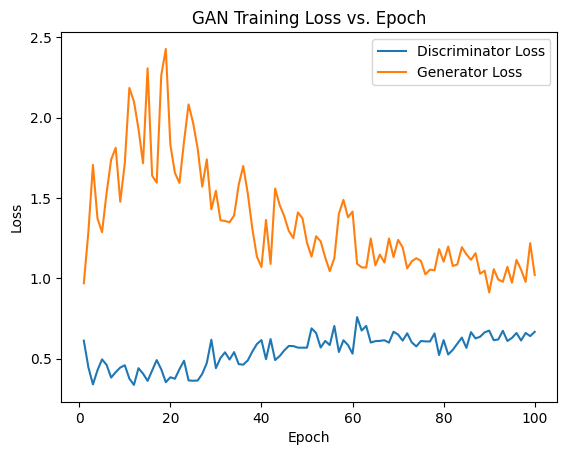

Generated Airfoils


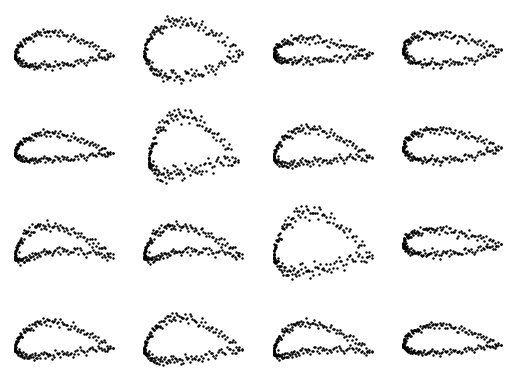

In [59]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# define dataset and dataloader
dataset = AirfoilDataset()
airfoil_x = dataset.get_x()
airfoil_dim = airfoil_x.shape[0]
airfoil_dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# hyperparameters
latent_dim = 16 # please do not change latent dimension
lr_dis = 0.0002 # discriminator learning rate
lr_gen = 0.0002 # generator learning rate
num_epochs = 100

# build the model
dis = Discriminator(input_dim=airfoil_dim).to(device)
gen = Generator(latent_dim=latent_dim, airfoil_dim=airfoil_dim).to(device)
print("Distrminator model:\n", dis)
print("Generator model:\n", gen)

print("Hyperparameters:")
print(f"latent dimension: {latent_dim}")
print(f"learning rate of Discriminator: {lr_dis}")
print(f"learning rate of Generator: {lr_gen}")
print(f"number of epochs: {num_epochs}")

# define your GAN loss function here
# you may need to define your own GAN loss function/class
# loss = ?

# GAN Loss function
criterion = nn.BCELoss()

def gan_loss(output, target):
    return criterion(output, target)

# define optimizer for discriminator and generator separately
optim_dis = Adam(dis.parameters(), lr=lr_dis)
optim_gen = Adam(gen.parameters(), lr=lr_gen)

# # train the GAN model
# for epoch in range(num_epochs):
#     for n_batch, (local_batch, __) in enumerate(airfoil_dataloader):
#         y_real = local_batch.to(device)

#         # train discriminator

#         # calculate customized GAN loss for discriminator
#         # enc_loss = loss(...)

#         optim_dis.zero_grad()
#         loss_dis.backward()
#         optim_dis.step()

#         # train generator

#         # calculate customized GAN loss for generator
#         # enc_loss = loss(...)

#         optim_gen.zero_grad()
#         loss_gen.backward()
#         optim_gen.step()

#         # print loss while training
#         if (n_batch + 1) % 30 == 0:
#             print("Epoch: [{}/{}], Batch: {}, Discriminator loss: {}, Generator loss: {}".format(
#                 epoch, num_epochs, n_batch, loss_dis.item(), loss_gen.item()))

# training begins

# Lists to store losses
dis_losses = []
gen_losses = []

# train the GAN model
for epoch in range(num_epochs):
    dis_epoch_loss = 0.0  # Initialize discriminator epoch loss
    gen_epoch_loss = 0.0  # Initialize generator epoch loss
    for n_batch, (local_batch, __) in enumerate(airfoil_dataloader):
        y_real = local_batch.to(device)

        # Train Discriminator
        optim_dis.zero_grad()
        
        # Discriminator on real data
        output_real = dis(y_real)
        loss_real = gan_loss(output_real, torch.ones_like(output_real))
        
        # Discriminator on generated data
        noise = torch.randn((y_real.size(0), latent_dim)).to(device)
        y_fake = gen(noise)
        output_fake = dis(y_fake.detach())
        loss_fake = gan_loss(output_fake, torch.zeros_like(output_fake))
        
        # Total discriminator loss
        loss_dis = (loss_real + loss_fake) / 2
        loss_dis.backward()
        optim_dis.step()
        dis_epoch_loss += loss_dis.item()


        # Train Generator
        optim_gen.zero_grad()
        
        # Generator loss
        output_gen = dis(y_fake)
        loss_gen = gan_loss(output_gen, torch.ones_like(output_gen))
        loss_gen.backward()
        optim_gen.step()
        gen_epoch_loss += loss_gen.item()

    # Calculate average epoch loss
    dis_epoch_loss /= len(airfoil_dataloader)
    gen_epoch_loss /= len(airfoil_dataloader)
    dis_losses.append(dis_epoch_loss)  # Append discriminator epoch loss to the list
    gen_losses.append(gen_epoch_loss)  # Append generator epoch loss to the list


    # print loss while training
    # if (n_batch + 1) % 30 == 0:
    print("Epoch: [{}/{}], Batch: {}, Discriminator loss: {:.4f}, Generator loss: {:.4f}".format(epoch, num_epochs, n_batch, loss_dis.item(), loss_gen.item()))

# Plot GAN training loss vs. epoch
plt.plot(range(1, num_epochs + 1), dis_losses, label='Discriminator Loss')
plt.plot(range(1, num_epochs + 1), gen_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Loss vs. Epoch')
plt.legend()
plt.show()

# training ends
            

# test trained GAN model
num_samples = 100
# create random noise 
noise = torch.randn((num_samples, latent_dim)).to(device)
# generate airfoils
gen_airfoils = gen(noise)
if 'cuda' in device:
    gen_airfoils = gen_airfoils.detach().cpu().numpy()
else:
    gen_airfoils = gen_airfoils.detach().numpy()

# Save Discriminator model
torch.save(dis.state_dict(), 'discriminator.pth')

# Save Generator model
torch.save(gen.state_dict(), 'generator.pth')


# plot generated airfoils
print("Generated Airfoils")
plot_airfoils(airfoil_x, gen_airfoils)

## Comparative Analysis of Synthesized Airfoils by Variational Autoencoder (VAE) and Generative Adversarial Network (GAN)

### 1. Visual Quality:
- **Variational Autoencoder (VAE):**
  - VAE-generated airfoils exhibit a remarkable smoothness and continuity, closely resembling the input distribution.
  - The output demonstrates coherence and fidelity to the learned features, resulting in visually pleasing representations.
- **Generative Adversarial Network (GAN):**
  - GAN-produced airfoils showcase a broader range of diversity and variability.
  - However, the generated airfoils may lack the smoothness and consistency observed in VAE-generated counterparts.
- *Note: The disparity in visual quality may be attributed to the intrinsic characteristics of the models. Unlike architectures employing convolutional neural networks for image generation, both VAE and GAN here operate on a vector-based representation of airfoil coordinates.*

### 2. Training Losses:
- **Variational Autoencoder (VAE):**
  - The VAE's training loss exhibits a consistent exponential decrease until epoch 5, followed by convergence to a constant value.
  - This signifies the VAE's ability to accurately capture and reproduce the underlying distribution of the training data.
- **Generative Adversarial Network (GAN):**
  - The training losses for the discriminator and generator in GAN display considerable fluctuations.
  - Initially, the discriminator's loss increases before declining and converging, while the generator's loss fluctuates before slightly increasing.
  - Importantly, both the discriminator and generator losses converge to proximate values, indicating successful training and convergence of the model.
  
### Conclusion:
- The VAE excels in producing airfoils with smoother transitions and adherence to learned features, making it suitable for applications where fidelity to input data is crucial.
- In contrast, the GAN offers a wider range of variability, albeit with potential trade-offs in smoothness and coherence. This diversity can be advantageous in scenarios requiring exploration of diverse design spaces.
- Both models demonstrate convergence in training, albeit with distinct loss trajectories, suggesting effective learning and generation of airfoil data.
